# Unsupervised Learning - Restricted Boltzmann Machines
For this second tutorial we will discuss and implement a simple Restricted Boltzmann machine(RBM) for image reconstruction. 

## Unsupervised Learning
RBM's are an unsupervised machine learning algorithm, meaning there is not ground truth labels for the data. Unsupervised algorithms are practical in that you often have a lot of data but much of it, if not all of it, is unlabeled. It can also be argued that humans learning primarily via unsupervised learning(we are not constantly given explicit labels when learning). The ability to exploit the abundance of data we have which is unlabeled is the primary goal for the research done in unsupervised learning.

A popular method of unsupervised machine learning is reconstruction. If the model can accurately reconstruct the input data then it has likely learned a good internal representation of the data which can be used for other tasks such as classification, dimensionality reduction, or regression. In neural network literature there are a few popular reconstruction methods including the following:
- Restricted Boltzmann Machines
- Autoencoders
- Generative Adversarial Networks

We will begin our discussion of unsupervised neural network algorithms with RBM's due to their historical significance and ease of implementation but will revisit Autoencoders and GAN's in future tutorials.

We start with importing the libraries we will need for this tutorial.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from load_data import load_data  #a helper utility function to load MNIST data

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Restricted Boltzmann Machines
The structure of an RBM can be seen below. It is a 1 layer neural network but the connections between the 'visible' input layer and 'hidden' layer are undirected. This means an RBM is an undirected bipartite graph.

![rbm](rbm.png)

Determining the hidden layers activations $a$ is the same as with a normal neural network. We perform a forward pass by multiplication with the weight matrix $W$ and add the bias. To reconstruct the input we perform a "backward pass" by multiplying the hidden weight activations with $W^T$ and adding the visible unit bias. 

**Forward Pass**
$$a = s(Wx + b_{hidden})$$

**Backward Pass**
$$v = s(W^Ta + b_{visible})$$

Where $s$ is our activation function. As with our simple neural network we will use the sigmoid activation function.

In [2]:
def sigmoid(X):
    """Computes sigmoid activation of input data"""
    return 1. / (1 + np.exp(-X))

It is commonly the case that we consider binary units and binary data. This simplifies the computation a bit but the forward and backward pass then give us a distribution to sample from instead of the unit activation values themselves. This means we have the following definition 

**Forward Pass**
$$P(a=1 | v) = s(Wv + b_{hidden})$$

**Backward Pass**
$$P(v=1 | a) = s(Wa + b_{visible})$$

Thus in the forward pass we are sampling hidden units given the visible units and in the backward pass we are sampling the visible units given the hidden units. To train this type of model we must first discuss energy based models.

## Energy Based Models
Energy based models associate a single scalar (energy) with each configuration of the variables in the model. Learning with this type of model corresponds to changing the energy of the configuration. In our case we are seeking to minimize the total energy of our RBM model. We now define the energy of the joint configuration of hidden and visible units

$$E(v,a) = -a^TWv - b_{visible}v - b_{hidden}a$$

The probability of a joint configuration can then be given by the **Boltzmann distribution**

$$p(v,a) = exp(-E(v,a))/Z$$
$$Z = \sum_{v,a}exp(-E(v,a))$$

Where $Z$ is the **partition function**. Note that this sum is intractable for any decently sized model. We can now evaluate the marginal distribution $p(v)$

$$\begin{align*}
p(v) &= \sum_{a\in\{ 0,1\} }p(v,a) = \sum_{a\in\{ 0,1\} }exp(-E(v,a))/Z \\
&= exp(b_{visible}^Tv + \sum_{j=1}^Hlog(1+exp(b_j+W_jv)))/Z
\end{align*}$$

If we define $F(v) = -log\sum_he^{-E(v,a)}$ to be the **free energy** then the negative log-likelihood gradient has the following form

$$-\frac{\partial logp(v)}{\partial \theta} = \frac{\partial F(v)}{\partial \theta} - \sum_\hat{v}p(\hat{v})\frac{\partial F(\hat{v})}{\partial \theta}$$

## Contrastive Divergence
The second term in the negative log-likelihood is difficult to compute as it involves an expectation over all possible configurations of $v$ which can be an enormous number of configurations to explore. To train RBM's we instead use contrastive divergence which replaces the expectation with a point estimate at $\hat{v}$. We obtain this point by Gibbs sampling which is just the process of performing the forward and backward pass through our RBM $k$ times. At the end of this process we will have an estimate $\hat{v}$ for which we can use in the estimate of the negative log likelihood term. 

$$-\frac{\partial logp(v)}{\partial \theta} = \frac{\partial F(v)}{\partial \theta} - \frac{1}{|N |}\sum_{\hat{v}\in N}\frac{\partial F(\hat{v})}{\partial \theta}$$

A visualization of contrastive divergence is shown below. We can see that it is a repeated sampling of $v$ and $a$ through our RBM that gives us the end point sample.
![Contrastive divergence](cd.png)

Where $N$ is the set of our point estimates. Now we have everything we need to perform the minimization of the negative log likelihood. We simply take the derivative with respect to our parameters and perform gradient descent with the gradient updates. The update equations are shown without proof below:

$$\begin{align*}
-\frac{\partial logp(v)}{\partial W_{ij}} &= E_v[ p(a_j | v_j) * v_j ] - v_j^{(i)} * s(W_iv^{(i)} + b_{visible_i})\\
-\frac{\partial logp(v)}{\partial b_{visible_i}} &= E_{v}[ p(h_i | v) ] - s(W_i * v^{(i)}) \\
-\frac{\partial logp(v)}{\partial b_{hidden_j}} &= E_v[ p(v_j | h) ] - v_j^{(i)}
\end{align*}$$

As with normal neural networks we can add momentum or other tweaks to improve training time but we will stick with simple stochastic gradient descent.

## Performance Metrics
Since RBM's are a type of unsupervised learning, there is no definitive metric to monitor how the model is doing. In this tutorial, since we are using binary inputs we can use cross-entropy as our metric to monitor reconstruction performance. We can also visualize our weights to see if they are learning good visual features.

Another way to check how good the features are is to sample digits from our model. This is the same as performing Gibbs sampling but instead of initializing with the data, we initialize randomly and see what the RBM outputs. If the RBM has learned a good internal representation of the data then it should have modeled the data distribution well. And if it has a good model of the data distribution then it should be able to sample this distribution and produce good images of digits.

In [3]:
class RBM(object):
    """ Restricted Boltzmann Machine (RBM) """
    def __init__(self, X_train, X_val, nb_vis=28*28, nb_hidden=500,np_rng=None):
        self.X_train = X_train
        self.X_val = X_val

        self.nb_vis = nb_vis
        self.nb_hidden = nb_hidden

        if np_rng is None:
            np_rng = np.random.RandomState(1234)

        self.W =  np.random.randn(nb_vis,  nb_hidden) / np.sqrt(nb_vis)

        self.hbias = np.zeros(nb_hidden)
        self.vbias = np.zeros(nb_vis)

        self.np_rng = np_rng

    def sample_h_given_v(self, v0_sample):
        """Sample hidden activations given visible unit activations"""
        h1_mean = sigmoid(v0_sample.dot(self.W) + self.hbias)
        h1_sample = self.np_rng.binomial(size=h1_mean.shape, n=1, p=h1_mean)
        return [h1_mean, h1_sample]

    def sample_v_given_h(self, h0_sample):
        """Sample visual units given the hidden unit activations"""
        v1_mean = sigmoid(h0_sample.dot(self.W.T) + self.vbias)
        v1_sample = self.np_rng.binomial(size=v1_mean.shape, n=1, p=v1_mean)
        return [v1_mean, v1_sample]

    def gibbs_hvh(self, h0_sample):
        """Performs one iteration of Gibbs sampling"""
        v1_mean, v1_sample = self.sample_v_given_h(h0_sample)
        h1_mean, h1_sample = self.sample_h_given_v(v1_sample)
        return [v1_mean, v1_sample,
                h1_mean, h1_sample]

    def calc_cross_entropy(self,X):
        """Computes cross entropy"""
        total_cross_entropy = 0
        for i in xrange(X.shape[0]):
            x = X[0,:]
            h_mean, h_sample = self.sample_h_given_v(x)
            v_mean, v_sample = self.sample_v_given_h(h_sample)

            cross_entropy = 0
            eps = 10**(-10)
            cross_entropy += np.sum(x * np.log(v_mean+eps) + (1-x) * np.log(1-v_mean+eps))

            total_cross_entropy += cross_entropy
        return - total_cross_entropy

    def get_cost_updates(self, lr=0.1, k=1):
        """Performs Gibbs sampling and weight updates"""
        ph_mean, ph_sample = self.sample_h_given_v(self.X_train)

        for step in xrange(k):
            if step == 0:
                nv_means, nv_samples,\
                nh_means, nh_samples = self.gibbs_hvh(ph_sample)
            else:
                nv_means, nv_samples,\
                nh_means, nh_samples = self.gibbs_hvh(nh_samples)

            self.W += lr * (((np.dot(self.X_train.T, ph_mean)
                    - np.dot(nv_samples.T, nh_means))) / self.X_train.shape[0])
            self.vbias += lr * (np.mean(self.X_train - nv_samples, axis=0) / self.X_train.shape[0])
            self.hbias += lr * (np.mean(ph_mean - nh_means, axis=0) / self.X_train.shape[0])

            #Reconstruction loss
            monitoring_cost = np.mean(np.square(self.X_train - nv_means))

            #Reconstruction cross-entropy
            train_cross_entropy = self.calc_cross_entropy(self.X_train) / self.X_train.shape[0]
            val_cross_entropy = self.calc_cross_entropy(self.X_val) / self.X_val.shape[0]

        return train_cross_entropy, val_cross_entropy

# Data
The dataset of choice is the commonly used MNIST dataset. This dataset consists of 28x28 images of digits 0-9. The goal of our RBM model will this be to reconstruct digits. In our case, since we are not performing classification or regression we will not be using the test set.

In [4]:
train, val, test = load_data('mnist.pkl.gz')

train_X, train_y = train
val_X, val_y = val
test_X, test_y = test

print "Number of training examples: {}".format(train_X.shape[0])
print "Number of testing examples: {}".format(test_X.shape[0])

... loading data
Number of training examples: 50000
Number of testing examples: 10000


Since we are training a binary RBM model we first binarize our input data to either be 0 or 1. This is not strictly neccesary but is mathematically sound for the derivations shown above. Try not binarizing the data to see what you get!

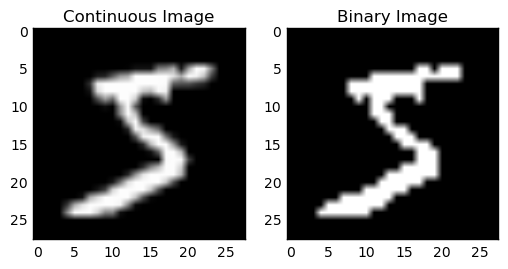

In [5]:
train_X_binary = np.where(train_X > 0.5, 1.0, 0.0)
val_X_binary = np.where(val_X > 0.5, 1.0, 0.0)

plt.subplot(1,2,1)
plt.imshow(train_X[0,:].reshape([28,28]), cmap='gray')
plt.title('Continuous Image')
plt.subplot(1,2,2)
plt.imshow(train_X_binary[0,:].reshape([28,28]), cmap='gray')
plt.title('Binary Image')

## Training
Now we train! I have set the number of iterations of Gibbs sampling to 10 $(k=10)$, the number of hidden units to 500, and learning rate to $0.1$. We train for a total of 50 epochs. Note that this code is not well optimized so it will take a while to perform each iteration. Using mini-batches instead of stochastic gradient descent could speed things up a bit but that is left as an exercise to the reader.

In [6]:
#Set hyperparameters
nb_epoch = 50
nb_hidden_units = 100
learning_rate = 0.1
k=10

rbm = RBM(train_X_binary, val_X_binary, nb_vis=28 * 28, nb_hidden=nb_hidden_units)
train_costs = []
val_costs = []

for epoch in xrange(nb_epoch):
    train_cost, val_cost = rbm.get_cost_updates(lr=learning_rate, k=k)
    train_costs.append(train_cost)
    val_costs.append(val_cost)
    print 'Training epoch %d, cost is ' % epoch, train_cost

Training epoch 0, cost is  616.565997265
Training epoch 1, cost is  248.536723761
Training epoch 2, cost is  246.298384976
Training epoch 3, cost is  1088.01167865
Training epoch 4, cost is  226.265021745
Training epoch 5, cost is  874.531923403
Training epoch 6, cost is  287.726350345
Training epoch 7, cost is  244.177651874
Training epoch 8, cost is  224.439905975
Training epoch 9, cost is  215.265552668
Training epoch 10, cost is  199.331979335
Training epoch 11, cost is  204.027818158
Training epoch 12, cost is  192.099314026
Training epoch 13, cost is  189.646682211
Training epoch 14, cost is  185.044039776
Training epoch 15, cost is  180.156001908
Training epoch 16, cost is  177.39099371
Training epoch 17, cost is  173.139948966
Training epoch 18, cost is  171.178900057
Training epoch 19, cost is  168.405400965
Training epoch 20, cost is  166.712166855
Training epoch 21, cost is  164.241920977
Training epoch 22, cost is  162.044109761
Training epoch 23, cost is  159.702935787
Tra

## Analysis
Now we take a look at how our RBM performed over time. We also analyze its learned features and how well it can generate new samples from the MNIST dataset

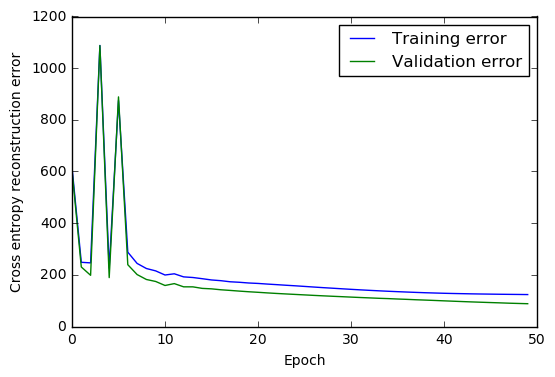

In [7]:
plt.plot(train_costs)
plt.plot(val_costs)
plt.xlabel('Epoch')
plt.ylabel('Cross entropy reconstruction error')
plt.legend(['Training error','Validation error'])

We can see from the plot that the learning is initially very noisy but then proceeds to decrease in cross entropy error over each epoch. This makes sense as initially the weights are random which are probably not good features to model the data distribution.

### Visualizing Learned Features

In [8]:
def visualize_weights(W):
    """Helper function to visualize RBM weights"""
    img = np.zeros([28*10,28*10])
    k = 0
    for i in xrange(10):
        for j in xrange(10):
            x = i*28
            y = j*28
            f = W[:,k]
            img[x:x+28,y:y+28] = np.reshape(f,[28,28])
            k += 1
    return img

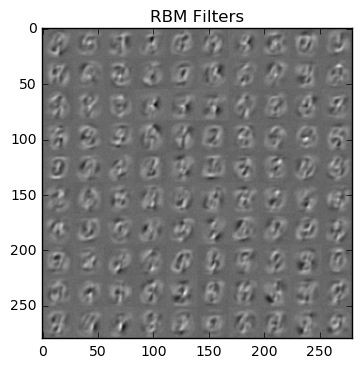

In [9]:
visualized_w = visualize_weights(rbm.W)
plt.imshow(visualized_w, cmap='gray')
plt.title('RBM Filters')

Though the learned features are not ideal we can see they are roughly learned the edges of various digits. Some improvements could be made to  improve the features which have been suggested in the ideas at the end of this tutorial. 

### Generating Samples from our Learned RBM

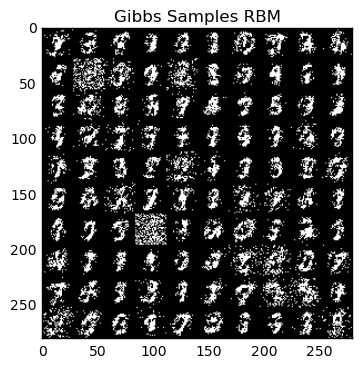

In [11]:
out = np.zeros([100,28*28])
for i in xrange(100):
    x = np.random.randn(1,28*28)
    ph_mean, ph_sample = rbm.sample_h_given_v(x)

    for j in xrange(1000):
        v1_mean, v1_sample, h1_mean, h1_sample = rbm.gibbs_hvh(ph_sample)

    out[i,:] = v1_sample

gibb_chains = visualize_weights(out.T)
plt.imshow(gibb_chains,cmap='gray')
plt.title('Gibbs Samples RBM')

Though our samples are very noisy, some of them resemble digits very closely! Though not amazing it is a good place to start your unsupervised learning ventures. There are plenty of knobs to tweak in RBM models and many other things one can add to improve these types of models. Below are just a few things you can try. In future tutorials we will explore other neural network based unsupervised algorithms which are used much more in current state-of-the-art methods.

## Ideas to Try
- Using persistent constrastive divergence instead of simple contrastive divergence
- Initialize a neural networks weights with the weights learned by the RBM. This has been shown to improve training speed in some simple cases.

## Other Resources
If you want more details about any of the derivations or simply want more information I encourage you to check out the following resources:
- [Geoff Hinton on Boltzmann Machines](http://www.scholarpedia.org/article/Boltzmann_machine)
- [Deeplearning.net Restricted Boltzmann Machine Tutorial](http://deeplearning.net/tutorial/rbm.html)
- [A Practical Guide to Training Restricted Boltzmann Machines](https://www.cs.toronto.edu/~hinton/absps/guideTR.pdf)
- [Ruslan Salakhutdinov's Deep Learning Course](http://www.cs.cmu.edu/~rsalakhu/10807_2016/Lectures/Lecture_RBMs.pdf)